In [1]:
%matplotlib inline
from collections import Counter
from collections import defaultdict
import glob
from decimal import Decimal
import os
import seaborn as sns
import pandas as pd
from matplotlib import image
import numpy as np
import pybedtools
import subprocess
from gscripts.general import dataviz
from collections import OrderedDict
from clipper.src import CLIP_analysis

img_dir = "/nas3/gpratt/Dropbox/TAF15/Data/GP_TAF15_CLIP_motif/"

In [37]:
name_map = {"taf15": "TAF15",
           "fus": "FUS",
           "tdp43": "TDP43"}

style_map = {"taf15": "-",
           "fus": "--",
           "tdp43": "--"}

color_map = {"fus": '#43A247',
              'taf15': '#DB1D3D',
              'tdp43': '#712878',
              'fus_taf15': 'c',
              'taf15_tdp43': 'c'}

background_dict_map = {"TDP43brainclip": "tdp43",
                       "TAF15": "taf15",
                       "TLS": "fus",}

In [3]:
#motif generation code
#example
#/nas3/gpratt/projects/fet_family/data/stuff_for_KK/TAF15_combined_notrim_ingenes_clusters_mm950.bed_homer/all/homerResults -> scanMotifGenomeWide.pl motif1.motif mm9 -bed > motif1.bed
    
#sorting code
#sort -k 1,1 -k 2,2n motif1.bed > motif1.sorted.bed

In [4]:
def closest_hist(bedtool, motiftool):
    cloest_tool = bedtool.closest(motiftool, s=True, D="a", t="first")
    distances = [int(interval[-1]) for interval in cloest_tool if interval[9] != "none"]
    hist, bins = np.histogram(distances, range=(-500, 500), bins=50)
    bins = [(bins[n] + bins[n+1]) / 2 for n in range(len(bins) - 1)]
    normalized_hist = hist / (len(bedtool) * 1.0)
    return normalized_hist, bins

def get_midpoint(interval):
    midpoint = (interval.start + interval.end) / 2
    interval.start = midpoint
    interval.end = midpoint + 1
    return interval

def get_homer_values(fn):
    with open(fn) as motif:
        header = motif.readline().strip().split()
        stats = header[-1].split(",")
        pvalue = Decimal(stats[2].split(":")[1])
        target = float(stats[0].split("(")[1][:-2])
        background = float(stats[1].split("(")[1][:-2])
        return target, background, pvalue

def move_name(interval):
    interval.name = interval[12]
    return interval

def annotatePeaks(peaks, motif, species="hg19", hist=10, size=1000):
    
    """
    
    runs homer with standard args
    output location is saved
    
    foreground - str, location of fasta file for the foreground distribution
    background - str, location of fasta file for the background distribution
    k - different k-mers to examine
    outloc - directory to output homer results 

    --make optional make work off locations and not fasta files 
    
    """
    #findMotifs.pl clusters.fa fasta outloc -nofacts p 4 -rna -S 10 -len 5,6,7,8,9 -noconvert -nogo -fasta background.fa
    #converts k to a string for use in subprocess
    
    try:
        with open("tmp.txt", 'w') as out:
            subprocess.call(["annotatePeaks.pl",
                             peaks,
                             species,
                             "-m", motif,
                             "-hist", str(hist),
                             "-size", str(size),
                             "-noann"], shell=False, stdout=out)
    except OSError:
        print "Homer not installed, ignoring motif generation, install homer for this to work"  
        raise   
    return pd.read_table("tmp.txt", index_col=0)

In [6]:
motifs = {"all_motif_1": pybedtools.BedTool("/nas3/gpratt/projects/fet_family/data/stuff_for_KK/TAF15_combined_notrim_ingenes_clusters_mm950.bed_homer/all/homerResults/motif1.sorted.bed"),
          "all_motif_2": pybedtools.BedTool("/nas3/gpratt/projects/fet_family/data/stuff_for_KK/TAF15_combined_notrim_ingenes_clusters_mm950.bed_homer/all/homerResults/motif2.sorted.bed"),
          "utr3_motif_1": pybedtools.BedTool("/nas3/gpratt/projects/fet_family/data/stuff_for_KK/TAF15_combined_notrim_ingenes_clusters_mm950.bed_homer/three_prime_utrs/homerResults/motif1.sorted.bed"),
          "utr3_motif_2": pybedtools.BedTool("/nas3/gpratt/projects/fet_family/data/stuff_for_KK/TAF15_combined_notrim_ingenes_clusters_mm950.bed_homer/three_prime_utrs/homerResults/motif2.sorted.bed"),
          }

background = glob.glob("/nas3/gpratt/iPython_Notebook/taf15/assigned/*bed.all.rand*")
background_rbps = {os.path.basename(bedtool): pybedtools.BedTool(bedtool).each(get_midpoint).sort().saveas() for bedtool in background}

In [5]:
#used to be pybedtool pybedtools.BedTool(
rbps = {"taf15": "/nas3/gpratt/projects/fet_family/data/stuff_for_KK/TAF15_combined_notrim_ingenes_clusters_mm950.bed",
 "fus": "/nas3/gpratt/projects/fet_family/data/stuff_for_KK/TLS_hiseq_notrim_ingenes_clusters_mm950.bed",
 "tdp43": "/nas3/gpratt/projects/fet_family/data/stuff_for_KK/TDP43brainclip_MP41_kcomb_notrim_ingenes_clusters_mm950.bed",
 }

In [ ]:
dist_dict = defaultdict(dict)
for rbp in rbps:
    for motif in motifs:
        dist_dict[motif][rbp] = closest_hist(rbps[rbp], motifs[motif])

background_dist_dict = defaultdict(dict)
for rbp in background_rbps:
    for motif in motifs:
        background_dist_dict[motif][rbp] = closest_hist(background_rbps[rbp], motifs[motif])
        
cloest_tool = rbps['tdp43'].closest(motifs["all_motif_1"], s=True, D="a", t="first")
distances = [int(interval[-1]) for interval in cloest_tool if interval[9] != "none"]
all_hist, all_bins = np.histogram(distances, range=(-500, 500), bins=50)
all_normalized_hist = all_hist / (len(background_rbps[rbp]) * 1.0)

cloest_tool = background_rbps[rbp].closest(motifs["all_motif_1"], s=True, D="a", t="first")
distances = [int(interval[-1]) for interval in cloest_tool if interval[9] != "none"]
control_hist, control_bins = np.histogram(distances, range=(-500, 500), bins=50)
control_normalized_hist = control_hist / (len(background_rbps[rbp]) * 1.0)

In [ ]:
sumed_background_dist_dict = defaultdict(dict)
for motif in background_dist_dict.keys():
    for rbp in background_dist_dict[motif].keys():
        hist, bins = background_dist_dict[motif][rbp]
        rbp_name = background_dict_map[rbp.split("_")[0]]
        
        if rbp_name not in sumed_background_dist_dict[motif]:
            sumed_background_dist_dict[motif][rbp_name] = hist
        else:
            sumed_background_dist_dict[motif][rbp_name] += hist

In [11]:
regions = OrderedDict()
regions["cds"] = "CDS"
regions["three_prime_utrs"] = "3' UTR"
regions["five_prime_utrs"] = "5' UTR"
regions["proxintron500"] = "Proximal\nIntron"
regions["distintron500"] = "Distal\nIntron"



genes = pybedtools.BedTool("/nas3/gpratt/clipper/clipper/data/regions/mm9_genes.bed")

rbps = {"taf15": pybedtools.BedTool("/nas3/gpratt/projects/fet_family/data/stuff_for_KK/TAF15_combined_notrim_ingenes_clusters_mm950.bed"),
        "fus": pybedtools.BedTool("/nas3/gpratt/projects/fet_family/data/stuff_for_KK/TLS_hiseq_notrim_ingenes_clusters_mm950.bed"),
        "tdp43": pybedtools.BedTool("/nas3/gpratt/projects/fet_family/data/stuff_for_KK/TDP43brainclip_MP41_kcomb_notrim_ingenes_clusters_mm950.bed"),
 }

assigned_rbps = {}
for name, rbp in rbps.items():
    overlapping_genes = rbp.intersect(genes, wo=True, s=True).each(move_name).saveas()

    assigned_rbps[name] = CLIP_analysis.assign_to_regions(overlapping_genes, os.path.splitext(rbp.fn)[0], 
                                    regions, "assigned", nrand=3, species="mm9")

There are a total 69657 clusters I'll examine
For region: cds found 521 that overlap and 69136 that don't
For region: three_prime_utrs found 2999 that overlap and 66137 that don't
For region: five_prime_utrs found 194 that overlap and 65943 that don't
For region: proxintron500 found 8425 that overlap and 57518 that don't
For region: distintron500 found 57457 that overlap and 61 that don't
After assigning 61 un-categorized regions
There are a total 155599 clusters I'll examine
For region: cds found 13193 that overlap and 142406 that don't
For region: three_prime_utrs found 10705 that overlap and 131701 that don't
For region: five_prime_utrs found 944 that overlap and 130757 that don't
For region: proxintron500 found 21211 that overlap and 109546 that don't
For region: distintron500 found 109329 that overlap and 217 that don't
After assigning 217 un-categorized regions
There are a total 44610 clusters I'll examine
For region: cds found 1470 that overlap and 43140 that don't
For region: t

In [18]:
all_motif1_image = "/nas3/gpratt/projects/fet_family/data/stuff_for_KK/TAF15_combined_notrim_ingenes_clusters_mm950.bed_homer/all/homerResults/motif1.logo.png"
all_motif1_image = image.imread(all_motif1_image)

utr3_motif1_image = "/nas3/gpratt/projects/fet_family/data/stuff_for_KK/TAF15_combined_notrim_ingenes_clusters_mm950.bed_homer/three_prime_utrs/homerResults/motif1.logo.png"
utr3_motif1_image = image.imread(utr3_motif1_image)

all_motif1_file = "/nas3/gpratt/projects/fet_family/data/stuff_for_KK/TAF15_combined_notrim_ingenes_clusters_mm950.bed_homer/all/homerResults/motif1.motif"
all_motif1_target, all_motif1_background, all_motif1_pvalue = get_homer_values(all_motif1_file)

utr3_motif1_file = "/nas3/gpratt/projects/fet_family/data/stuff_for_KK/TAF15_combined_notrim_ingenes_clusters_mm950.bed_homer/three_prime_utrs/homerResults/motif1.motif"
utr3_motif1_target, utr3_motif1_background, utr3_motif1_pvalue = get_homer_values(utr3_motif1_file)

all_motif2_image = "/nas3/gpratt/projects/fet_family/data/stuff_for_KK/TAF15_combined_notrim_ingenes_clusters_mm950.bed_homer/all/homerResults/motif2.logo.png"
all_motif2_image = image.imread(all_motif2_image)

utr3_motif2_image = "/nas3/gpratt/projects/fet_family/data/stuff_for_KK/TAF15_combined_notrim_ingenes_clusters_mm950.bed_homer/three_prime_utrs/homerResults/motif2.logo.pdf"
utr3_motif2_image = image.imread(utr3_motif2_image)

all_motif2_file = "/nas3/gpratt/projects/fet_family/data/stuff_for_KK/TAF15_combined_notrim_ingenes_clusters_mm950.bed_homer/all/homerResults/motif2.motif"
all_motif2_target, all_motif2_background, all_motif2_pvalue = get_homer_values(all_motif2_file)

utr3_motif2_file = "/nas3/gpratt/projects/fet_family/data/stuff_for_KK/TAF15_combined_notrim_ingenes_clusters_mm950.bed_homer/three_prime_utrs/homerResults/motif2.motif"
utr3_motif2_target, utr3_motif2_background, utr3_motif2_pvalue = get_homer_values(utr3_motif2_file)

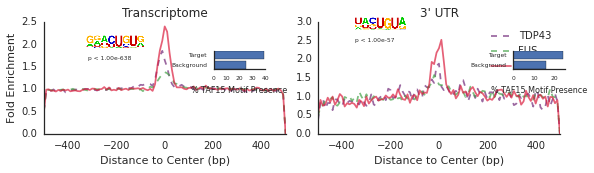

In [38]:
num_rows = 1
num_cols = 2
subax_rect_1 = [.1, .7, .2, .1]
bar_plot_rect_1 = [.38, .60, .09, .1]
bar_plot_rect_2 = [.9, .60, .09, .1]
subax_rect_2 = [.56, .8, .2, .1]

with dataviz.Figure(os.path.join(img_dir, "distance.svg"), figsize=(num_cols * 4,num_rows * 2.5)) as fig:
    #All Regions Code
    ax = fig.add_subplot(num_rows,num_cols,1)
    for rbp in rbps:
        result = annotatePeaks(peaks=assigned_rbps[rbp]['all']['real'].fn, motif=all_motif1_file, species="mm9")
        result = result[result.columns[1]]
        ax.plot(result.index, 
                result / np.median(result),
                label=name_map[rbp],
                linestyle=style_map[rbp], 
                color= color_map[rbp],
                alpha=.7)
        
    ax.set_xlim(-500, 500)
    ax.set_title("Transcriptome")
    ax.set_ylabel("Fold Enrichment")
    ax.set_xlabel("Distance to Center (bp)")
    
    #Plot the Motif
    subax = fig.add_axes(subax_rect_1)
    subax.imshow(all_motif1_image)
    sns.despine(bottom=True,left=True, ax=subax)
    subax.set_xticks([])
    subax.set_yticks([])
    subax.set_xlabel('p < {:.2e}'.format(all_motif1_pvalue), fontsize=6)
    sns.despine(ax=ax)

    #Plot the bar char
    ax = fig.add_axes(bar_plot_rect_1)
    pos = np.arange(2)
    ax.barh(pos, [all_motif1_background, all_motif1_target], align="center")
    ax.set_yticks(pos)
    ax.set_yticklabels(["Background", "Target"], fontsize=8)
    ax.set_xticks(ax.get_xticks()[::2])
    sns.despine(ax=ax)
    ax.set_xlabel("% TAF15 Motif Presence", fontsize=8)
    [tick.set_fontsize(6) for tick in ax.get_yticklabels()]
    [tick.set_fontsize(6) for tick in ax.get_xticklabels()]

    #3' UTR Code
    ax = fig.add_subplot(num_rows,num_cols,2)
    subax = fig.add_axes(subax_rect_2)
    
    for rbp in rbps:
        result = annotatePeaks(peaks=assigned_rbps[rbp]['three_prime_utrs']['real'].fn, motif=utr3_motif1_file, species="mm9")
        result = result[result.columns[1]]
        ax.plot(result.index, 
                result / np.median(result),
                label=name_map[rbp],
                linestyle=style_map[rbp], 
                color= color_map[rbp],
                alpha=.7)
        
    ax.set_xlim(-500, 500)
    ax.legend(loc=0)
    subax.imshow(utr3_motif1_image)
    sns.despine(bottom=True,left=True, ax=subax)
    subax.set_xticks([])
    subax.set_yticks([])
    subax.set_xlabel('p < {:.2e}'.format(utr3_motif1_pvalue), fontsize=6)
    sns.despine(ax=ax)
    ax.set_title("3' UTR")
    ax.set_xlabel("Distance to Center (bp)")
    
    #Plot the bar char
    ax = fig.add_axes(bar_plot_rect_2)
    pos = np.arange(2)
    ax.barh(pos, [utr3_motif1_background, utr3_motif1_target], align="center")
    ax.set_yticks(pos)
    ax.set_yticklabels(["Background", "Target"], fontsize=8)
    ax.set_xticks(ax.get_xticks()[::2])
    sns.despine(ax=ax)
    ax.set_xlabel("% TAF15 Motif Presence", fontsize=8)
    [tick.set_fontsize(6) for tick in ax.get_yticklabels()]
    [tick.set_fontsize(6) for tick in ax.get_xticklabels()]

Figure Legend: Distance of TAF15 Motifs away from binding sites, FUS and TDP43 used as background control for motif in whole transcriptome and 3' UTR were used in this analysis

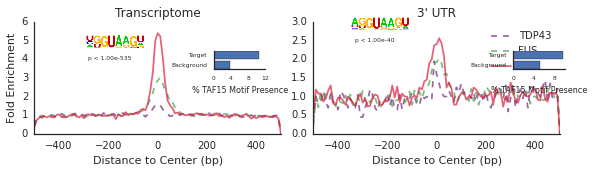

In [40]:
num_rows = 1
num_cols = 2
subax_rect_1 = [.1, .7, .2, .1]
bar_plot_rect_1 = [.38, .60, .09, .1]
bar_plot_rect_2 = [.9, .60, .09, .1]
subax_rect_2 = [.56, .8, .2, .1]

with dataviz.Figure(os.path.join(img_dir, "distance_second_best.svg"), figsize=(num_cols * 4,num_rows * 2.5)) as fig:
    #All Regions Code
    ax = fig.add_subplot(num_rows,num_cols,1)
    for rbp in rbps:
        result = annotatePeaks(peaks=assigned_rbps[rbp]['all']['real'].fn, motif=all_motif2_file, species="mm9")
        result = result[result.columns[1]]
        ax.plot(result.index, 
                result / np.median(result),
                label=name_map[rbp],
                linestyle=style_map[rbp], 
                color= color_map[rbp],
                alpha=.7)
        
    ax.set_xlim(-500, 500)
    ax.set_title("Transcriptome")
    ax.set_ylabel("Fold Enrichment")
    ax.set_xlabel("Distance to Center (bp)")
    
    #Plot the Motif
    subax = fig.add_axes(subax_rect_1)
    subax.imshow(all_motif2_image)
    sns.despine(bottom=True,left=True, ax=subax)
    subax.set_xticks([])
    subax.set_yticks([])
    subax.set_xlabel('p < {:.2e}'.format(all_motif2_pvalue), fontsize=6)
    sns.despine(ax=ax)

    #Plot the bar char
    ax = fig.add_axes(bar_plot_rect_1)
    pos = np.arange(2)
    ax.barh(pos, [all_motif2_background, all_motif2_target], align="center")
    ax.set_yticks(pos)
    ax.set_yticklabels(["Background", "Target"], fontsize=8)
    ax.set_xticks(ax.get_xticks()[::2])
    sns.despine(ax=ax)
    ax.set_xlabel("% TAF15 Motif Presence", fontsize=8)
    [tick.set_fontsize(6) for tick in ax.get_yticklabels()]
    [tick.set_fontsize(6) for tick in ax.get_xticklabels()]

    #3' UTR Code
    ax = fig.add_subplot(num_rows,num_cols,2)
    subax = fig.add_axes(subax_rect_2)
    
    for rbp in rbps:
        result = annotatePeaks(peaks=assigned_rbps[rbp]['three_prime_utrs']['real'].fn, motif=utr3_motif2_file, species="mm9")
        result = result[result.columns[1]]
        ax.plot(result.index, 
                result / np.median(result),
                label=name_map[rbp],
                linestyle=style_map[rbp], 
                color= color_map[rbp],
                alpha=.7)
        
    ax.set_xlim(-500, 500)
    ax.legend(loc=0)
    subax.imshow(utr3_motif2_image)
    sns.despine(bottom=True,left=True, ax=subax)
    subax.set_xticks([])
    subax.set_yticks([])
    subax.set_xlabel('p < {:.2e}'.format(utr3_motif2_pvalue), fontsize=6)
    sns.despine(ax=ax)
    ax.set_title("3' UTR")
    ax.set_xlabel("Distance to Center (bp)")
    
    #Plot the bar char
    ax = fig.add_axes(bar_plot_rect_2)
    pos = np.arange(2)
    ax.barh(pos, [utr3_motif2_background, utr3_motif2_target], align="center")
    ax.set_yticks(pos)
    ax.set_yticklabels(["Background", "Target"], fontsize=8)
    ax.set_xticks(ax.get_xticks()[::2])
    sns.despine(ax=ax)
    ax.set_xlabel("% TAF15 Motif Presence", fontsize=8)
    [tick.set_fontsize(6) for tick in ax.get_yticklabels()]
    [tick.set_fontsize(6) for tick in ax.get_xticklabels()]

In [33]:
def fun(foo, bar):
    return foo + bar

In [35]:
result = fun(5, 7)

In [36]:
print result + 10

22
